# Explore here

In [ ]:
import pandas as pd
import numpy as np, random
import statsmodels.api as sm
import datetime
#https://4geeks.com/es/syllabus/spain-ds-pt-10/project/alternative-time-series-project

In [43]:
df_rd = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
df_rd.to_csv("/workspaces/Proyecto-JBG.SerieTemporalAlternativa/data/raw/df_rd.csv", index=False)
df_rd.head(4)

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899


In [44]:
#PASO 1, DARLE FORMATO A LA FECHA DE LAS MUESTRAS.
df_rd["dateYMD"] = pd.to_datetime(df_rd["date"], format='mixed')
df_rd["dateYMD"] = df_rd["dateYMD"].dt.date
df_rd.head(3),



(                         date      sales     dateYMD
 0  2022-09-03 17:10:08.079328  55.292157  2022-09-03
 1  2022-09-04 17:10:08.079328  53.803211  2022-09-04
 2  2022-09-05 17:10:08.079328  58.141693  2022-09-05,)

In [45]:
#Ya tenemos nuestra columnas de fechas con el formato YMD.
#dropeamos la columna antigua de fechas.
df_rd_YMD = df_rd.drop("date", axis=1)
df_rd_YMD.to_csv("/workspaces/Proyecto-JBG.SerieTemporalAlternativa/data/raw/df_rd.csv", index=False)
df_rd_YMD.head(3),

(       sales     dateYMD
 0  55.292157  2022-09-03
 1  53.803211  2022-09-04
 2  58.141693  2022-09-05,)

In [46]:
#Vamos a poner la columna dateYMD como indice default del dataframe, creando un dataframe con indice en formato
#fecha y una sola columna con las ventas'sales'
df_rd_YMD = df_rd_YMD.set_index('dateYMD')
df_ds = df_rd_YMD[['sales']]
df_ds.to_csv("/workspaces/Proyecto-JBG.SerieTemporalAlternativa/data/raw/df_rd_indexed.csv", index=True)
df_ds.head(3)


,sales
dateYMD,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693


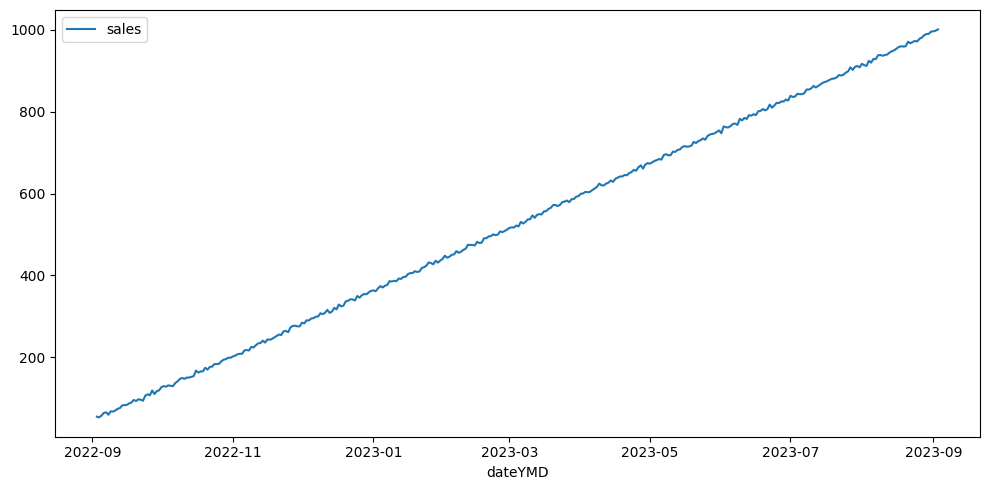

In [48]:
#vamos a graficar nuestros datos.
import matplotlib.pyplot as plt
import seaborn as sns
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = df_ds)
plt.tight_layout()
plt.show()

In [ ]:
#Vamos a realizar un seasonal decompose para poder trabajar estadisticamente con los datos.
